_Note: Additional packages beyond SpatialFusion are required to walkthrough this tutorial. We supply a ready to use environment file `spatialfusion_env.yml`._

In [1]:
# Standard library
import logging
import os
import warnings
import pathlib as pl

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import shapely.wkb
import tifffile
import timm
import torch
from PIL import Image
from tqdm.notebook import tqdm
from torchvision import transforms

# Warning filters
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

⚠️ You might run into some issues with torchtext, an error like 

```
OSError: /ewsc/yatesjos/spatialfusion_env/lib/python3.10/site-packages/torchtext/lib/libtorchtext.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
```

If so, you migh have to downgrade torch, see https://github.com/pytorch/text/issues/2272

We recommend using CUDA 12.1 to play well with this code, see main README for installation details.

# Download and read in data

The tutorial uses processed H&E and spatial transcriptomics (ST) data which is publicly available here: https://zenodo.org/records/17594071. This data is a crop of the [5k Ovarian Cancer Xenium experiment](https://www.10xgenomics.com/datasets/xenium-prime-ffpe-human-ovarian-cancer). 

Once you have downloaded the data, please put it in the `data/` folder of tutorials or change the paths accordingly to point to the downloaded data.

_Note: This method **requires** at least the H&E high-resolution image and X and Y coordinates extracted through segmentation (see the tutorial on extracting embeddings from H&E only). Paired ST data is optional._

**Read in spatial transcriptomics data**

At minimum, the adata object **must** contain:
- adata.obsm['spatial']: this should contain the X and Y coordinates of the cell/nuclei centroid in the high-resolution pixel space of the associated WSI.
- adata.X: this should be the cell x gene matrix of raw counts (! this needs to be single-cell resolution data)
- (optional): adata.obs['celltype']: the annotated celltypes (here called 'major_celltype').

In [3]:
adata = sc.read_h5ad('data/tutadata_subset.h5ad')
adata

AnnData object with n_obs × n_vars = 46691 × 5101
    obs: 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'minor_celltype', 'major_celltype', 'cell_id', 'X_coord', 'Y_coord'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'wsi_crop'
    obsm: 'spatial', 'spatial_he'

**Read in H&E WSI**

In [4]:
source_image_path = 'data/wsi_crop.ome.tif'

with tifffile.TiffFile(source_image_path) as tif:
    wsi = tif.series[0].asarray()

# I. Unimodal embeddings

SpatialFusion operates off of unimodal embeddings for H&E data and _optionally_ paired spatial transcriptomics (ST) data. 

Here, we demonstrate how to generate these unimodal embeddings for H&E and ST data using UNI2 and scGPT frozen foundation models.

First, you must download model checkpoints (saved weights of a pretrained model).

- H&E data
    - UNI2: https://huggingface.co/MahmoodLab/UNI2-h/tree/main (_Note: you must request access_)
- Spatial transcriptomics data
    - scGPT: https://figshare.com/articles/dataset/Data_used_for_demo_of_the_code_accompanying_the_i_Assessing_the_limits_of_zero-shot_foundation_models_in_single-cell_biology_i_paper_/24747228?file=43480497 

Replace the below paths with where you downloaded the model weights.

In [ ]:
PATH_SCGPT_WEIGHTS = pl.Path('/ewsc/yatesjos/Broad_SpatialFoundation/scGPT_model/')
PATH_UNI_WEIGHTS = pl.Path('/ewsc/yatesjos/Broad_SpatialFoundation/UNI/pytorch_model.bin')

## 1. scGPT

### Helper functions

We leverage functions from the [zero-shot-scfoundation](https://github.com/microsoft/zero-shot-scfoundation?tab=readme-ov-file) GitHub repository, specifically those found in the `sc_foundation_evals` folder. Clone this repository via:

```bash
git clone https://github.com/microsoft/zero-shot-scfoundation.git
```

Then, below, modify the sys path to include the parent directory where `sc_foundation_evals` is located to be able to use the functions.

In [9]:
import sys
sys.path.append('../../../Broad_SpatialFoundation/')

from sc_foundation_evals import cell_embeddings, scgpt_forward, data, model_output
from sc_foundation_evals.helpers.custom_logging import log

log.setLevel(logging.INFO)

/ewsc/yatesjos/spatialfusion_env/lib/python3.10/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/ewsc/yatesjos/spatialfusion_env/lib/python3.10/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/ewsc/yatesjos/spatialfusion_env/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/ewsc/yatesjos/spatialfusion_env/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last release

In [ ]:
def run_embed_scGPT(
    dataset_path: str,
    model_dir: str,  # path to the pre-trained model, 3 files are expected: model_weights (best_model.pt), model args (args.json), and model vocab (vocab.json)
    output_dir: str,  # output_dir is the path to which the results should be saved
    n_hvg: int,
    gene_col: str = "index",  # in which column in adata.obs are gene names stored? if they are in index, the index will be copied to a column with this name
    layer_key: str = "X",  # where the raw counts are stored?
    log_norm: bool = False,  # are the values log_norm already?
    seed: int = 42,
    max_seq_len: int = 1200,  # maximum sequence of the input is controlled by max_seq_len, here I'm using the pretrained default
    batch_size: int = 32,  # batch_size depends on available GPU memory; should be a multiple of 8
    input_bins: int = 51,
    model_run: str = "pretrained",
    num_workers: int = 0,  # if you can use multithreading specify num_workers
) -> None:


    # create the model
    scgpt_model = scgpt_forward.scGPT_instance(
        saved_model_path=model_dir,
        model_run=model_run,
        batch_size=batch_size,
        save_dir=output_dir,
        num_workers=num_workers,
        explicit_save_dir=True,
    )

    # create config
    scgpt_model.create_configs(seed=seed, max_seq_len=max_seq_len, n_bins=input_bins)

    scgpt_model.load_pretrained_model()

    # This is to keep the model running if the amount of genes is small
    input_data = data.InputData(adata_dataset_path=dataset_path)
    vocab_list = scgpt_model.vocab.get_stoi().keys()

    adata = input_data.adata
    genes_in_vocab = adata.var_names.intersection(vocab_list)
    if len(genes_in_vocab) / len(adata.var_names) < 0.5:
        log.warning("Fewer than 50% of genes are found in the model vocab — continuing anyway.")
    
    adata._inplace_subset_var(genes_in_vocab)
    input_data.adata = adata

    input_data.preprocess_data(
        gene_vocab=vocab_list,
        model_type="scGPT",
        gene_col=gene_col,
        data_is_raw=not log_norm,
        counts_layer=layer_key,
        n_bins=input_bins,
        n_hvg=n_hvg,
    )

    scgpt_model.tokenize_data(
        data=input_data, input_layer_key="X_binned", include_zero_genes=False
    )

    scgpt_model.extract_embeddings(data=input_data)

    pd.DataFrame(
        input_data.adata.obsm["X_scGPT"],
        index=input_data.adata.obs["cell_id"] if "cell_id" in input_data.adata.obs.columns else input_data.adata.obs.index
    ).to_parquet(pl.Path(output_dir) / "scGPT.parquet")


### Generate embeddings

In [ ]:
# change this to wherever you saved the data 
base_dir = pl.Path('data/')
sample_name = 'SUBSET_Xenium_Ovarian-5k'
adata_path = base_dir / "tutadata_subset.h5ad"

model_dir_GPT = PATH_SCGPT_WEIGHTS

In [36]:
print(f'Starting for {sample_name}')
run_embed_scGPT(
    dataset_path=str(adata_path),
    model_dir=str(model_dir_GPT),
    output_dir=str(base_dir),  
    n_hvg=1200,
    gene_col="index",
    layer_key="X",
    log_norm=False,
    seed=42,
    max_seq_len=1200,
    batch_size=16,
    input_bins=51,
    model_run="pretrained",
    num_workers=0,
)

INFO     | 2025-10-23 11:04:42 | Using device cuda
WARNING  | 2025-10-23 11:04:42 | Overriding pre-trained config['save_dir'] with data (was /scratch/ssd004/datasets/cellxgene/save/cellxgene_census_human-May23-08-36-2023)
WARNING  | 2025-10-23 11:04:42 | Overriding pre-trained config['max_seq_len'] with 1200 (was 1200)
INFO     | 2025-10-23 11:04:42 | Loading vocab from /ewsc/yatesjos/Broad_SpatialFoundation/scGPT_model/vocab.json


Starting for SUBSET_Xenium_Ovarian-5k


INFO     | 2025-10-23 11:04:42 | Loading model from /ewsc/yatesjos/Broad_SpatialFoundation/scGPT_model/best_model.pt
WARNING  | 2025-10-23 11:04:43 | Loading partial model params from /ewsc/yatesjos/Broad_SpatialFoundation/scGPT_model/best_model.pt
WARNING  | 2025-10-23 11:04:43 | Cannot load transformer_encoder.layers.0.self_attn.in_proj_weight with shape torch.Size([1536, 512])
WARNING  | 2025-10-23 11:04:43 | Cannot load transformer_encoder.layers.0.self_attn.in_proj_bias with shape torch.Size([1536])
WARNING  | 2025-10-23 11:04:43 | Cannot load transformer_encoder.layers.1.self_attn.in_proj_weight with shape torch.Size([1536, 512])
WARNING  | 2025-10-23 11:04:43 | Cannot load transformer_encoder.layers.1.self_attn.in_proj_bias with shape torch.Size([1536])
WARNING  | 2025-10-23 11:04:43 | Cannot load transformer_encoder.layers.2.self_attn.in_proj_weight with shape torch.Size([1536, 512])
WARNING  | 2025-10-23 11:04:43 | Cannot load transformer_encoder.layers.2.self_attn.in_proj_bia

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...


INFO     | 2025-10-23 11:04:50 | Tokenizing data
INFO     | 2025-10-23 11:04:53 | Preparing dataloader
INFO     | 2025-10-23 11:04:53 | Saving config to data
INFO     | 2025-10-23 11:04:53 | Extracting embeddings
INFO     | 2025-10-23 11:04:53 | Extracting embeddings for batch 1/2919
INFO     | 2025-10-23 11:05:19 | Extracting embeddings for batch 292/2919
INFO     | 2025-10-23 11:05:43 | Extracting embeddings for batch 583/2919
INFO     | 2025-10-23 11:06:07 | Extracting embeddings for batch 874/2919
INFO     | 2025-10-23 11:06:31 | Extracting embeddings for batch 1165/2919
INFO     | 2025-10-23 11:06:55 | Extracting embeddings for batch 1456/2919
INFO     | 2025-10-23 11:07:19 | Extracting embeddings for batch 1747/2919
INFO     | 2025-10-23 11:07:43 | Extracting embeddings for batch 2038/2919
INFO     | 2025-10-23 11:08:07 | Extracting embeddings for batch 2329/2919
INFO     | 2025-10-23 11:08:30 | Extracting embeddings for batch 2620/2919
INFO     | 2025-10-23 11:08:54 | Extracting

## 2. UNI

### Helper functions

In [37]:
def load_UNI_model(model_path: str, device: str = "cuda"):
    timm_kwargs = {
        'model_name': 'vit_giant_patch14_224',
        'img_size': 224,
        'patch_size': 14,
        'depth': 24,
        'num_heads': 24,
        'init_values': 1e-5,
        'embed_dim': 1536,
        'mlp_ratio': 2.66667 * 2,
        'num_classes': 0,
        'no_embed_class': True,
        'mlp_layer': timm.layers.SwiGLUPacked,
        'act_layer': torch.nn.SiLU,
        'reg_tokens': 8,
        'dynamic_img_size': True
    }

    model = timm.create_model(pretrained=False, **timm_kwargs)
    model.load_state_dict(torch.load(model_path, map_location="cpu"), strict=True)
    model.eval().to(device)

    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225)),
    ])
    return model, transform


def embed_UNI(
    wsi, # whole-slide image as a NumPy array
    adata, # AnnData object; obs_names align with he_coords
    he_coords, # typically adata.obsm['spatial'], shape (n_spots, 2) with (x,y) pixel coords
    output_dir: str, # where to write embeddings, UNI.parquet
    model_path: str, # path to UNI weights
    batch_size: int = 128, # number of patches per forward pass
    device:str = "cuda", # "cuda" or "cpu"
):

    print('Load UNI model')
    model, transform = load_UNI_model(model_path, device)

    os.makedirs(output_dir, exist_ok=True)

    embeddings = []
    cell_ids = []
    
    batch_imgs = []
    batch_ids = []
    
    print(f"Embedding {len(he_coords)} image patches in batches of {batch_size}...")
    for cid, (x, y) in tqdm(zip(adata.obs_names, he_coords), total=len(adata)):
        x, y = int(x), int(y)
        x0, x1 = x - 128, x + 128
        y0, y1 = y - 128, y + 128
    
        pad_x0 = max(0, -x0)
        pad_x1 = max(0, x1 - wsi.shape[1])
        pad_y0 = max(0, -y0)
        pad_y1 = max(0, y1 - wsi.shape[0])
    
        patch = np.pad(
            wsi[max(0, y0):min(wsi.shape[0], y1), max(0, x0):min(wsi.shape[1], x1)],
            ((pad_y0, pad_y1), (pad_x0, pad_x1), (0, 0)),
            mode="constant"
        )
    
        if patch.shape[:2] != (256, 256):
            continue
    
        tensor_img = transform(Image.fromarray(patch))
        batch_imgs.append(tensor_img)
        batch_ids.append(cid)
    
        if len(batch_imgs) == batch_size:
            img_tensor = torch.stack(batch_imgs).to(device)
    
            with torch.inference_mode(), torch.autocast(device_type=device, dtype=torch.float16):
                batch_embs = model(img_tensor).to(torch.float16).cpu().numpy()
    
            embeddings.extend(batch_embs)
            cell_ids.extend(batch_ids)
            batch_imgs.clear()
            batch_ids.clear()
    
    # Final batch (if any)
    if batch_imgs:
        img_tensor = torch.stack(batch_imgs).to(device)
        with torch.inference_mode(), torch.autocast(device_type=device, dtype=torch.float16):
            batch_embs = model(img_tensor).to(torch.float16).cpu().numpy()
        embeddings.extend(batch_embs)
        cell_ids.extend(batch_ids)

    # Save embedding matrix
    df = pd.DataFrame(embeddings, index=cell_ids)
    df.to_parquet(f"{output_dir}/UNI.parquet")
    print(f"Saved {len(df)} embeddings to {output_dir}/UNI.parquet")    

### Generate embeddings

In [10]:
# set parameters to use with embed_UNI function
# specifically, output directory, cuda/cpu device, UNI model path,
# and h&e pixel coordinates
output_dir = 'data/'
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = PATH_UNI_WEIGHTS
he_coords = adata.obsm['spatial']

In [39]:
embed_UNI(
    wsi,
    adata,
    he_coords,
    output_dir,
    model_path,
    batch_size = 512,
    device = device
)

Load UNI model
Embedding 46691 image patches in batches of 512...


  0%|          | 0/46691 [00:00<?, ?it/s]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/ewsc/yatesjos/spatialfusion_env/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/ewsc/yatesjos/spatialfusion_env/lib/python3.10/site-packages/tqdm/_monitor.py", line 84, in run
    instance.refresh(nolock=True)
  File "/ewsc/yatesjos/spatialfusion_env/lib/python3.10/site-packages/tqdm/std.py", line 1347, in refresh
    self.display()
  File "/ewsc/yatesjos/spatialfusion_env/lib/python3.10/site-packages/tqdm/notebook.py", line 171, in display
    rtext.value = right
  File "/ewsc/yatesjos/spatialfusion_env/lib/python3.10/site-packages/traitlets/traitlets.py", line 716, in __set__
    self.set(obj, value)
  File "/ewsc/yatesjos/spatialfusion_env/lib/python3.10/site-packages/traitlets/traitlets.py", line 706, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/ewsc/yatesjos/spatialfusion_env/lib/python3.10/site-packages/traitlets/traitlets.py", line 1513, in _no

Saved 46691 embeddings to data//UNI.parquet


# II. & III. Multimodal and Spatial encoding

Once you've embedded the image and transcriptomic part, you can pass these embeddings through the pretrained multimodal AE and then through the GCMAE.

The pretrained checkpoints for the models can be found in the spatialfusion github (TODO, add link!) in the data/ folder. You will need to download them before continuing.

## Helper functions

In [5]:
import colorsys
from typing import Optional, Sequence, Mapping, Tuple, Dict, List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb, to_hex
from sklearn.decomposition import PCA

def plot_embeddings(
    z1, z2, z_joint, labels, samples, label_title,
    palette="tab10", seed=42, max_cells=500_000
):

    rng = np.random.default_rng(seed)

    df = pd.DataFrame({"sample": samples, "label": labels}, index=z1.index)
    df["idx"] = np.arange(len(df))
    grouped = df.groupby("sample")

    # Determine how many cells per sample to keep
    total_samples = len(grouped)
    max_per_sample = max_cells // max(1, total_samples)

    # Subsample per sample group
    selected_indices = []
    for _, group in grouped:
        n = min(len(group), max_per_sample)
        selected_indices.extend(rng.choice(group["idx"].values, size=n, replace=False))

    # Subset everything
    z1 = z1.iloc[selected_indices]
    z2 = z2.iloc[selected_indices]
    z_joint = z_joint.iloc[selected_indices]
    labels = np.array(labels)[selected_indices]
    samples = np.array(samples)[selected_indices]

    # Apply PCA
    pca = PCA(n_components=2)
    z1_pca = pca.fit_transform(z1.values)
    z2_pca = pca.fit_transform(z2.values)
    z_joint_pca = pca.fit_transform(z_joint.values)

    # Shuffle for plot order
    #perm = rng.permutation(len(labels))
    #z1_pca = z1_pca[perm]
    #z2_pca = z2_pca[perm]
    #z_joint_pca = z_joint_pca[perm]
    #labels = labels[perm]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    point_size = 5  # keep a single source of truth for both scatter and legend markers

    def _strip_spines(ax):
        # Remove ALL spines (no plot borders)
        for spine in ax.spines.values():
            spine.set_visible(False)
        # No ticks and equal aspect
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")

    def plot_scatter(ax, emb, title, show_legend=False):
        sns.scatterplot(
            x=emb[:, 0],
            y=emb[:, 1],
            hue=labels,
            palette=palette,
            s=point_size,
            ax=ax,
            linewidth=0,
            alpha=0.8,
            legend="full" if show_legend else False,
        )
        ax.set_title(title, fontsize=25)
        _strip_spines(ax)

    plot_scatter(axes[0], z1_pca, "H&E (PCA)")
    plot_scatter(axes[1], z2_pca, "RNA (PCA)")
    plot_scatter(axes[2], z_joint_pca, "Joint (PCA)", show_legend=True)

    # Extract and remove subplot legend
    handles, labels_ = axes[2].get_legend_handles_labels()
    if axes[2].legend_ is not None:
        axes[2].legend_.remove()

    # Make legend marker sizes match the scatter point size
    # (handles from seaborn are PathCollections for the color items)
    for h in handles:
        if hasattr(h, "set_sizes"):
            h.set_sizes([point_size])  # one marker per legend entry

    # Add shared figure legend (text size follows rcParams; markers already matched)
    fig.legend(
        handles,
        labels_,
        loc="center left",
        bbox_to_anchor=(1.01, 0.5),
        title=label_title,
        scatterpoints=1,     # one marker per legend entry
        markerscale=10,     # keep scale = 1 to respect set_sizes above
        frameon=False,       # optional: no border around the legend
        fontsize=16,        # control legend text size here
        title_fontsize=18,
    )

    plt.tight_layout()
    plt.show()


## Process sample

In [6]:
from spatialfusion.embed.embed import AEInputs, run_full_embedding

In [11]:
uni_df = pd.read_parquet(pl.Path(output_dir) / 'UNI.parquet')
scgpt_df = pd.read_parquet(pl.Path(output_dir) / 'scGPT.parquet')

Path to where the checkpoints are located:

In [12]:
ae_model_dir = pl.Path('../data/checkpoint_dir_ae/')
gcn_model_dir =  pl.Path('../data/checkpoint_dir_gcn/')

Now you can obtain directly the SpatialFusion embeddings for the sample

In [15]:
# can run this for several samples at a time
ae_inputs_by_sample = {
    sample_name: AEInputs(adata=adata, z_uni=uni_df, z_scgpt=scgpt_df),
}

# this uses the average version
emb_df = run_full_embedding(
    ae_inputs_by_sample=ae_inputs_by_sample,
    ae_model_path=ae_model_dir / "spatialfusion-multimodal-ae.pt",
    gcn_model_path=gcn_model_dir / "spatialfusion-full-gcn.pt", 
    device="cuda:0",
    combine_mode="average",
    spatial_key='spatial',
    celltype_key='major_celltype',
    save_ae_dir=None,  # optional
)

Running GCN inference: 100%|███████████████████████████████████| 1/1 [00:06<00:00,  6.70s/it]


In [16]:
emb_df.head(10)

0         1         2         3         4         5         6  \
0  0.105722  0.099298 -0.249925  0.013971 -0.183898 -0.188562 -0.110547   
1  0.103461  0.071382 -0.242062 -0.006037 -0.175699 -0.153991 -0.124109   
2  0.107087  0.087882 -0.246838  0.007794 -0.182903 -0.176664 -0.115847   
3  0.037572 -0.078778 -0.246964 -0.064057 -0.075595  0.122692 -0.202476   
4  0.023426 -0.099407 -0.225532 -0.079090 -0.070667  0.132277 -0.196780   
5  0.042911 -0.052489 -0.236254 -0.060673 -0.084839  0.086630 -0.195565   
6  0.034892 -0.091149 -0.236561 -0.064253 -0.075154  0.132361 -0.198921   
7  0.040943 -0.067320 -0.244633 -0.062780 -0.078841  0.107400 -0.197012   
8  0.029441 -0.103853 -0.247839 -0.057500 -0.067432  0.155465 -0.201170   
9  0.015861 -0.153000 -0.186100 -0.035860 -0.071418  0.168872 -0.159714   

          7         8         9                 sample_id     cell_id  \
0  0.168935  0.126048  0.299706  SUBSET_Xenium_Ovarian-5k  bodaggdc-1   
1  0.162561  0.157520  0.278603  SUBSET_Xenium_Ovarian-5k  bodahgja-1   
2  0.168505  0.136399  0.292705  SUBSET_Xenium_Ovarian-5k  bodalbfd-1   
3  0.095776  0.286289  0.122835  SUBSET_Xenium_Ovarian-5k  bodamehc-1   
4  0.098642  0.276366  0.135561  SUBSET_Xenium_Ovarian-5k  bodanfem-1   
5  0.101424  0.287390  0.111435  SUBSET_Xenium_Ovarian-5k  bodangii-1   
6  0.096637  0.280908  0.116497  SUBSET_Xenium_Ovarian-5k  bodaonoh-1   
7  0.097915  0.284010  0.119128  SUBSET_Xenium_Ovarian-5k  bodapgnj-1   
8  0.091579  0.279536  0.113419  SUBSET_Xenium_Ovarian-5k  bodaplcb-1   
9  0.119335  0.224643  0.055547  SUBSET_Xenium_Ovarian-5k  bodbdiel-1   

      celltype      X_coord      Y_coord  
0  Lymphocytes  8909.002585  8516.946833  
1  Lymphocytes  8839.379676  8573.668971  
2      Myeloid  8899.896676  8549.438262  
3      Myeloid  8062.427850  8699.193586  
4    Malignant  7948.017765  8781.114576  
5    Malignant  8090.523823  8734.000379  
6    Malignant  8044.218697  8709.041119  
7    Malignant  8096.092915  8698.008941  
8    Malignant  8041.488434  8658.176944  
9    Malignant  7884.713835  8622.031773

### Running only II. multimodal encoding

If you wish, you can also obtain the intermediate multimodal AE embeddings to inspect them.

In [17]:
from spatialfusion.embed.embed import load_paired_ae, ae_from_arrays

In [18]:
# Infer dimensions
d1_dim, d2_dim = ae_inputs_by_sample[sample_name].z_uni.shape[1], ae_inputs_by_sample[sample_name].z_scgpt.shape[1]

# Load AE model
ae_model = load_paired_ae(ae_model_dir / "spatialfusion-multimodal-ae.pt", d1_dim, d2_dim, latent_dim=64, device=device)

# Run AE embedding
z1_df, z2_df, z_joint_df = ae_from_arrays(
    ae_model,
    ae_inputs_by_sample[sample_name],
    device=device,
    combine_mode="average"  # or "concat", "z1", "z2"
)


In [19]:
labels_ct = adata.obs['major_celltype'].ravel()
labels_subct = adata.obs['minor_celltype'].ravel()

In [20]:
samples = [sample_name for _ in range(z1_df.shape[0])]

You can observe separation the distribution of cells types in PCA space of the pre-trained multimodal AE:

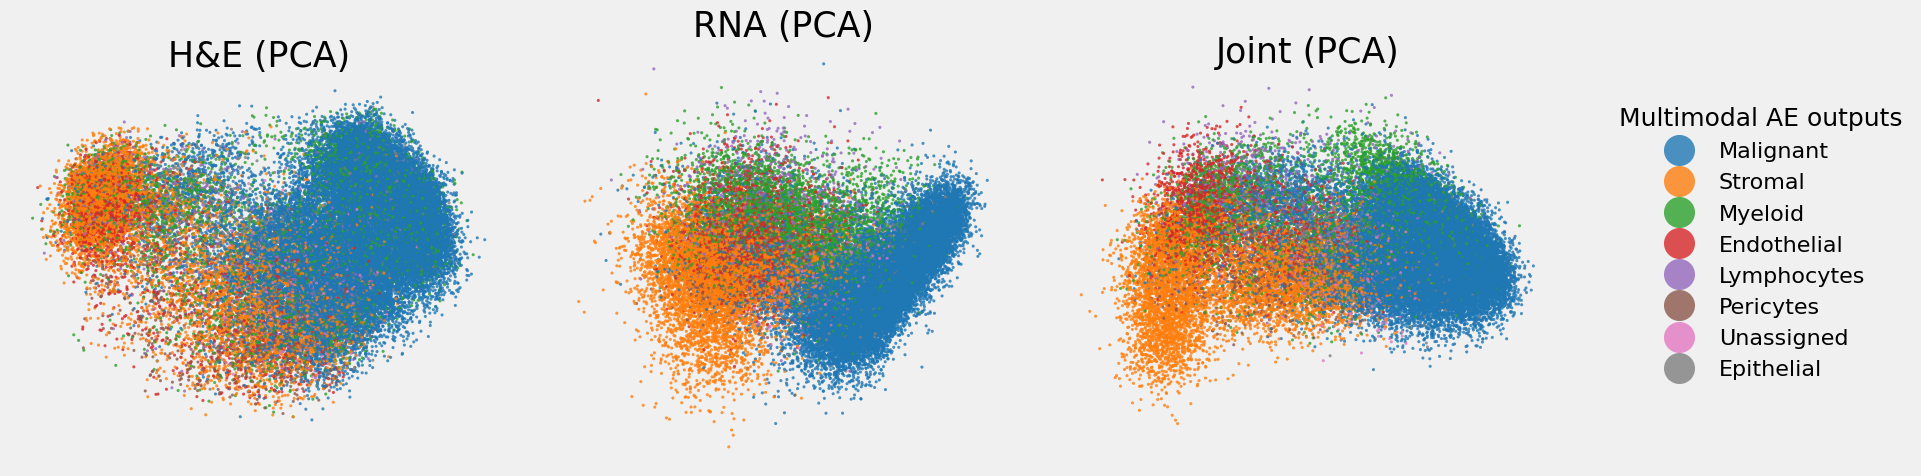

In [21]:
plot_embeddings(
    z1_df, z2_df, z_joint_df, labels_ct, samples, 'Multimodal AE outputs',
    palette="tab10", seed=42, max_cells=500_000
)

We see some separation is stronger in H&E space that RNA space, e.g., stromal cells form two clusters, and these seem to correspond to smooth muscle cells/stromal associated fibroblasts vs. tumor associated fibroblasts in the authors' annotations. Conversely, some separation is stronger in RNA space, e.g., proliferative tumor cells vs non-proliferative tumor cells. The joint space thus captures a middle ground. 

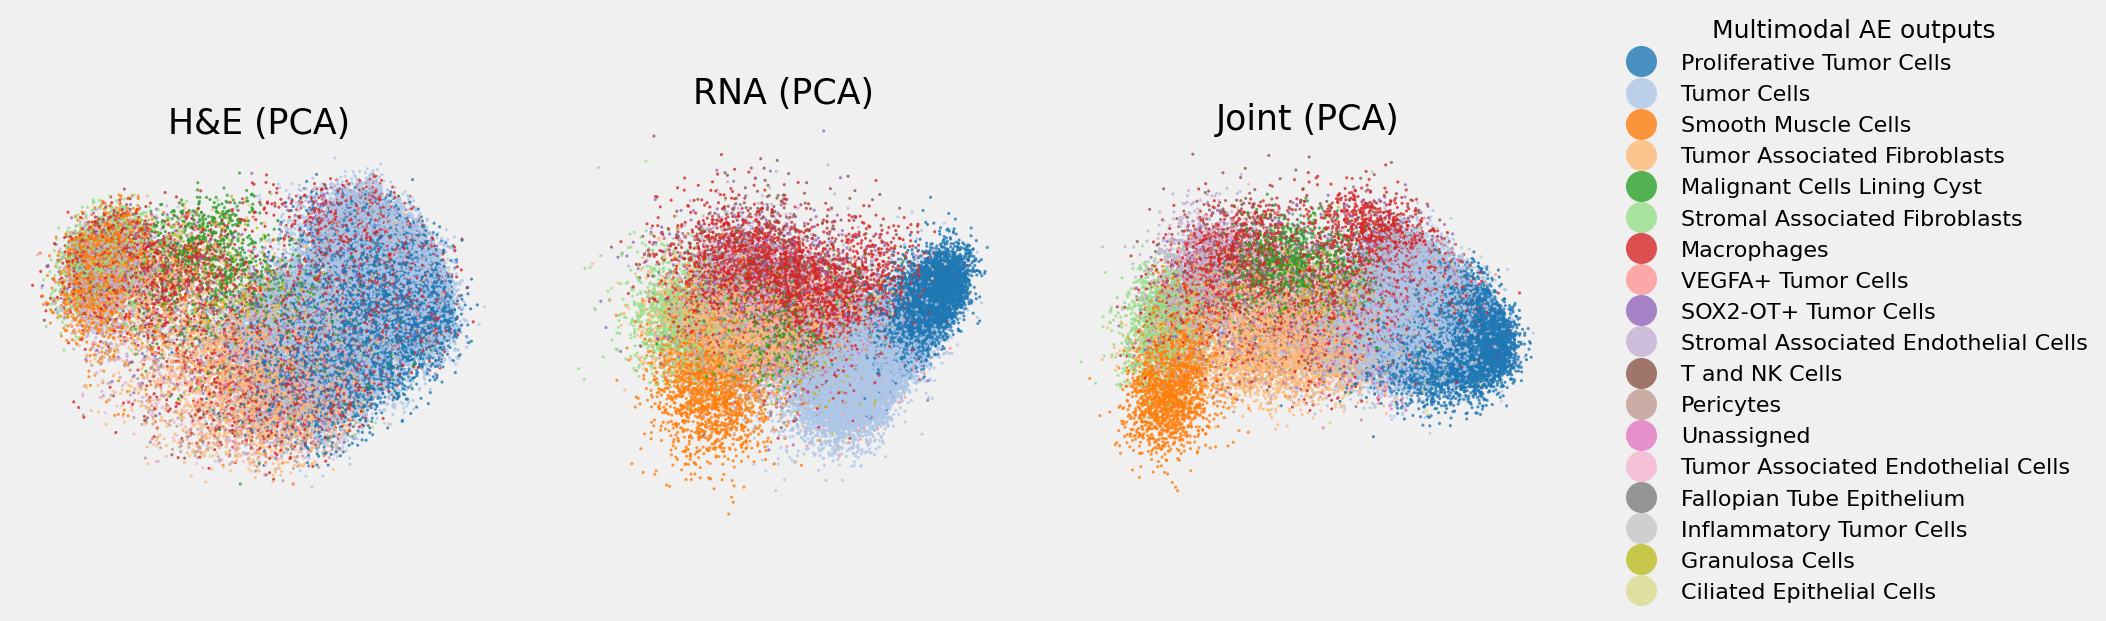

In [22]:
plot_embeddings(
    z1_df, z2_df, z_joint_df, labels_subct, samples, 'Multimodal AE outputs',
    palette="tab20", seed=42, max_cells=500_000
)

### Running only III. spatial encoding

Now you can run the GCN on the obtained embeddings.

In [23]:
from spatialfusion.embed.embed import load_gcn, gcn_embeddings_from_joint

In [24]:
# Suppose you concatenated AE joints across samples (index = cell ids from all samples)
# and you have each sample's adata in a dict.
# Keys must match the sample names you want in the output metadata.

adata_by_sample = {
    sample_name: adata,
}

gcn_model = load_gcn(gcn_model_dir / "spatialfusion-full-gcn.pt", in_dim=z_joint_df.shape[1], device="cuda")

gcn_emb_df = gcn_embeddings_from_joint(
    gcn_model=gcn_model,
    z_joint=z_joint_df,                # one big joint embedding over all cells
    adata_by_sample=adata_by_sample,   # per-sample AnnData objects
    base_path=".",                     # path for metadata lookups/saves
    device="cuda",
    spatial_key="spatial",             # or "spatial_px"
    celltype_key="major_celltype",
    k=30,
)


Running GCN inference: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 30.75it/s]


In [25]:
gcn_emb_df.head(10)

0         1         2         3         4         5         6  \
0  0.105722  0.099298 -0.249925  0.013971 -0.183898 -0.188562 -0.110547   
1  0.103461  0.071382 -0.242062 -0.006037 -0.175699 -0.153991 -0.124109   
2  0.107087  0.087882 -0.246838  0.007794 -0.182903 -0.176664 -0.115847   
3  0.037572 -0.078778 -0.246964 -0.064057 -0.075595  0.122692 -0.202476   
4  0.023426 -0.099407 -0.225532 -0.079090 -0.070667  0.132277 -0.196780   
5  0.042911 -0.052489 -0.236254 -0.060673 -0.084839  0.086630 -0.195565   
6  0.034892 -0.091149 -0.236561 -0.064253 -0.075154  0.132361 -0.198921   
7  0.040943 -0.067320 -0.244633 -0.062780 -0.078841  0.107400 -0.197012   
8  0.029441 -0.103853 -0.247839 -0.057500 -0.067432  0.155465 -0.201170   
9  0.015861 -0.153000 -0.186100 -0.035860 -0.071418  0.168872 -0.159714   

          7         8         9                 sample_id     cell_id  \
0  0.168935  0.126048  0.299706  SUBSET_Xenium_Ovarian-5k  bodaggdc-1   
1  0.162561  0.157520  0.278603  SUBSET_Xenium_Ovarian-5k  bodahgja-1   
2  0.168505  0.136399  0.292705  SUBSET_Xenium_Ovarian-5k  bodalbfd-1   
3  0.095776  0.286289  0.122835  SUBSET_Xenium_Ovarian-5k  bodamehc-1   
4  0.098642  0.276366  0.135561  SUBSET_Xenium_Ovarian-5k  bodanfem-1   
5  0.101424  0.287390  0.111435  SUBSET_Xenium_Ovarian-5k  bodangii-1   
6  0.096637  0.280908  0.116497  SUBSET_Xenium_Ovarian-5k  bodaonoh-1   
7  0.097915  0.284010  0.119128  SUBSET_Xenium_Ovarian-5k  bodapgnj-1   
8  0.091579  0.279536  0.113419  SUBSET_Xenium_Ovarian-5k  bodaplcb-1   
9  0.119335  0.224643  0.055547  SUBSET_Xenium_Ovarian-5k  bodbdiel-1   

      celltype      X_coord      Y_coord  
0  Lymphocytes  8909.002585  8516.946833  
1  Lymphocytes  8839.379676  8573.668971  
2      Myeloid  8899.896676  8549.438262  
3      Myeloid  8062.427850  8699.193586  
4    Malignant  7948.017765  8781.114576  
5    Malignant  8090.523823  8734.000379  
6    Malignant  8044.218697  8709.041119  
7    Malignant  8096.092915  8698.008941  
8    Malignant  8041.488434  8658.176944  
9    Malignant  7884.713835  8622.031773

In [26]:
gcn_emb_df.set_index('cell_id').to_parquet('data/SpatialFusion.parquet')

# Downstream analysis of SpatialFusion embeddings

In this section, we demonstrate how the SpatialFusion embeddings can be used to identify and interpret spatial niches, and how to analyze their organization within tissue.

## Helper functions

In [ ]:
def plot_cluster_composition_stacked(
    df,
    cluster_key: str = "leiden",
    type_key: str = "celltypes",                 # or "cellsubtypes"
    cluster_order: Optional[Sequence[str]] = None,
    strict_order: bool = False,                  # if True, only show clusters in cluster_order
    palette: Optional[Mapping[str, str]] = None, # dict {celltype: color}; auto if None
    top_types: Optional[int] = None,             # keep top N types globally, rest→"Other"
    min_frac: Optional[float] = None,            # keep types with global frac >= min_frac, rest→"Other"
    other_label: str = "Other",
    type_order: Optional[Sequence[str]] = None,  # custom order of stack segments
    figsize=(10, 5),
    percent_labels: bool = False,                # print % on bars
    label_threshold: float = 0.05,               # only label segments >=5%
    dpi: int = 150,
):
    """
    Plot a 100% stacked barplot of type proportions per cluster using adata.obs.
    Returns a long-form DataFrame with columns: [cluster, type, count, frac, percent]
    """
    obs = df[[cluster_key, type_key]].dropna().copy()
    obs[cluster_key] = obs[cluster_key].astype(str)
    obs[type_key]    = obs[type_key].astype(str)

    # Cross-tab counts (rows=clusters, cols=types)
    ct = pd.crosstab(obs[cluster_key], obs[type_key])

    # Global filtering of rare types (optional)
    keep_cols = ct.columns.tolist()
    if top_types is not None:
        keep_cols = (
            ct.sum(axis=0)
              .sort_values(ascending=False)
              .head(top_types)
              .index.tolist()
        )
    if min_frac is not None:
        global_frac = ct.sum(axis=0) / ct.values.sum()
        keep_cols = sorted(set(keep_cols) | set(global_frac[global_frac >= min_frac].index.tolist()))
    if (top_types is not None) or (min_frac is not None):
        other = ct.drop(columns=keep_cols, errors="ignore").sum(axis=1)
        ct = ct[keep_cols].copy()
        if (other > 0).any():
            ct[other_label] = other
        # make sure "Other" is last
        ct = ct[[c for c in ct.columns if c != other_label] + ([other_label] if other_label in ct.columns else [])]

    # Normalize rows to 1.0 (100%)
    row_sums = ct.sum(axis=1).replace(0, np.nan)
    props = ct.div(row_sums, axis=0).fillna(0.0)

    # Cluster reordering
    if cluster_order is not None:
        cluster_order = [str(c) for c in cluster_order]
        missing = [c for c in cluster_order if c not in props.index]
        if strict_order:
            props = props.reindex(cluster_order).dropna(how="all")
        else:
            extras = [c for c in props.index if c not in cluster_order]
            props = props.reindex(cluster_order + extras)
        if missing:
            print(f"Warning: these clusters from cluster_order were not found and will be skipped: {missing}")
    else:
        props = props.sort_index()

    if props.empty:
        raise ValueError("No clusters to plot after filtering/reordering.")

    # Determine stack (type) order
    types_order = props.columns.tolist()
    if type_order is not None:
        type_order = [t for t in type_order if t in props.columns]
        leftovers = [t for t in props.columns if t not in type_order]
        types_order = type_order + leftovers

    # Build color map
    if palette is None:
        base = sns.color_palette("tab10", n_colors=max(10, len(types_order)))
        colmap = dict(zip(types_order, base[:len(types_order)]))
        if other_label in types_order:
            colmap[other_label] = "#B0B0B0"  # gray for "Other"
    else:
        colmap = {t: palette.get(t, "#BBBBBB") for t in types_order}

    # Plot (stacked bars)
    plt.figure(figsize=figsize, dpi=dpi)
    bottom = np.zeros(len(props))
    x = np.arange(len(props.index))
    ax = plt.gca()

    for t in types_order:
        vals = props[t].values
        ax.bar(x, vals, bottom=bottom, width=0.9, color=colmap[t], label=t, edgecolor="none")
        bottom += vals

    ax.set_xticks(x)
    ax.set_xticklabels(props.index, rotation=45, ha="right")
    ax.set_ylim(0, 1)
    ax.set_ylabel("Composition (% of cells)")
    ax.set_xlabel(cluster_key)
    ax.set_title(f"{type_key} composition per {cluster_key}")

    if percent_labels:
        for i, cl in enumerate(props.index):
            cum = 0.0
            for t in types_order:
                h = props.loc[cl, t]
                if h >= label_threshold:
                    ax.text(i, cum + h/2, f"{h*100:.0f}%", ha="center", va="center", fontsize=8, color="white")
                cum += h

    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title=type_key)
    plt.tight_layout()
    plt.show()

    # Long-form result for downstream use
    plot_df = (
        props.reset_index()
             .melt(id_vars=cluster_key, var_name="type", value_name="frac")
             .rename(columns={cluster_key: "cluster"})
    )
    plot_df["percent"] = (plot_df["frac"] * 100).round(2)
    counts_long = (
        ct.reset_index()
          .melt(id_vars=cluster_key, var_name="type", value_name="count")
          .rename(columns={cluster_key: "cluster"})
    )
    plot_df = plot_df.merge(counts_long, on=["cluster", "type"], how="left")
    return plot_df

def _lightness_shades(hex_color: str, n: int,
                      l_low: float = 0.35, l_high: float = 0.85) -> List[str]:
    """Generate n shades by sweeping lightness in HLS while keeping hue & saturation."""
    r, g, b = to_rgb(hex_color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    if n <= 1:
        return [hex_color]
    Ls = np.linspace(l_low, l_high, n)
    shades = []
    for Li in Ls:
        ri, gi, bi = colorsys.hls_to_rgb(h, Li, s)
        shades.append(to_hex((ri, gi, bi)))
    return shades

def make_hierarchical_palettes(
    df,
    parent_key: str = "celltypes",
    child_key: str  = "cellsubtypes",
    parent_order: Optional[Sequence[str]] = None,   # optional desired order of lineages
    child_order: str = "alpha",                      # "alpha" or "freq"
    base_palette: Optional[Mapping[str, str]] = None,# optional {parent: hex}
    unknown_parent_color: str = "#9e9e9e",          # gray
    shade_lightness: Tuple[float, float] = (0.35, 0.85),
) -> Tuple[Dict[str, str], Dict[str, str], List[str], List[str]]:
    """
    Returns:
      parent_palette: {celltype -> hex}
      child_palette:  {cellsubtype -> hex} (shades of its parent color)
      parent_order_out: list of parents in chosen order
      child_order_out:  list of children grouped by parent in that order
    """
    obs = df[[parent_key, child_key]].copy()
    obs[parent_key] = obs[parent_key].astype(str)
    obs[child_key]  = obs[child_key].astype(str)

    # Parents present and their order
    parents = obs[parent_key].unique().tolist()
    if parent_order is not None:
        parent_order = [str(x) for x in parent_order]
        # keep requested order, append unseen parents at the end
        extra = [p for p in parents if p not in parent_order]
        parent_order_out = parent_order + extra
    else:
        # default: sort by global frequency, then alphabetically
        freq = obs[parent_key].value_counts()
        parent_order_out = (freq.index.tolist() +
                            [p for p in parents if p not in freq.index])

    # Children per parent
    children_per_parent = {}
    for p in parents:
        sub = obs.loc[obs[parent_key] == p, child_key]
        if child_order == "freq":
            children = sub.value_counts().index.tolist()
        else:
            children = sorted(sub.unique().tolist())
        children_per_parent[p] = children

    # Base colors for parents
    if base_palette is not None:
        parent_palette = {p: base_palette.get(p, unknown_parent_color) for p in parent_order_out}
    else:
        # distinct hues for parents
        n_par = len(parent_order_out)
        if n_par <= 10:
            base = sns.color_palette("tab10", n_colors=n_par)
        else:
            base = sns.color_palette("hls", n_colors=n_par)
        parent_palette = {p: to_hex(base[i]) for i, p in enumerate(parent_order_out)}

    # Shades for children
    child_palette = {}
    child_order_out = []
    l_low, l_high = shade_lightness
    for p in parent_order_out:
        base_col = parent_palette.get(p, unknown_parent_color)
        kids = children_per_parent.get(p, [])
        shades = _lightness_shades(base_col, max(1, len(kids)), l_low=l_low, l_high=l_high)
        for k, col in zip(kids, shades):
            child_palette[k] = col
        child_order_out.extend(kids)

    return parent_palette, child_palette, parent_order_out, child_order_out


## Identify spatial niches

Here, as in the paper, we use leiden clustering to identify spatial niches. 

Read in the SpatialFusion embeddings and add them to the adata object

In [ ]:
embeddings_df = pd.read_parquet('data/SpatialFusion.parquet')
adata.obsm['SpatialFusion'] = embeddings_df.loc[adata.obs_names,['0','1','2','3','4','5','6','7','8','9']]

Construct nearest neighbors distance matrix and perform leiden clustering

In [ ]:
sc.pp.neighbors(adata, use_rep='SpatialFusion')
sc.tl.leiden(adata, resolution=0.05, flavor="igraph", n_iterations=2)
# Display number of clusters
adata.obs.leiden.value_counts()

leiden
2    25599
0     7240
1     6221
5     4456
4     3167
3        8
Name: count, dtype: int64

## Visualize spatial niches in H&E space

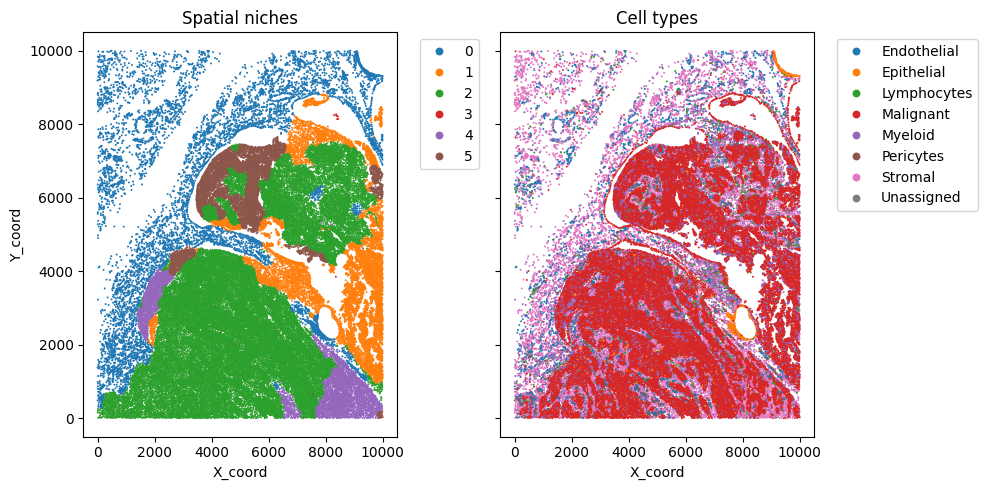

In [ ]:
adata.obs['leiden'] = adata.obs['leiden'].astype(str).astype('category')
plt.style.use('default')

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

# --- Plot 1: Spatial niches ---
sns.scatterplot(
    ax=axes[0],
    data=adata.obs,
    x='X_coord', y='Y_coord',
    hue='leiden',
    palette='tab10',
    s=2,
    linewidth=0
)
axes[0].invert_yaxis()
axes[0].set_title("Spatial niches")
axes[0].legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    scatterpoints=1,
    markerscale=4
)

# --- Plot 2: Cell types ---
sns.scatterplot(
    ax=axes[1],
    data=adata.obs,
    x='X_coord', y='Y_coord',
    hue='major_celltype',
    palette='tab10',
    s=2,
    linewidth=0
)
axes[1].invert_yaxis()
axes[1].set_title("Cell types")
axes[1].legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    scatterpoints=1,
    markerscale=4
)

plt.tight_layout()


## Characterize the cellular composition of spatial niches

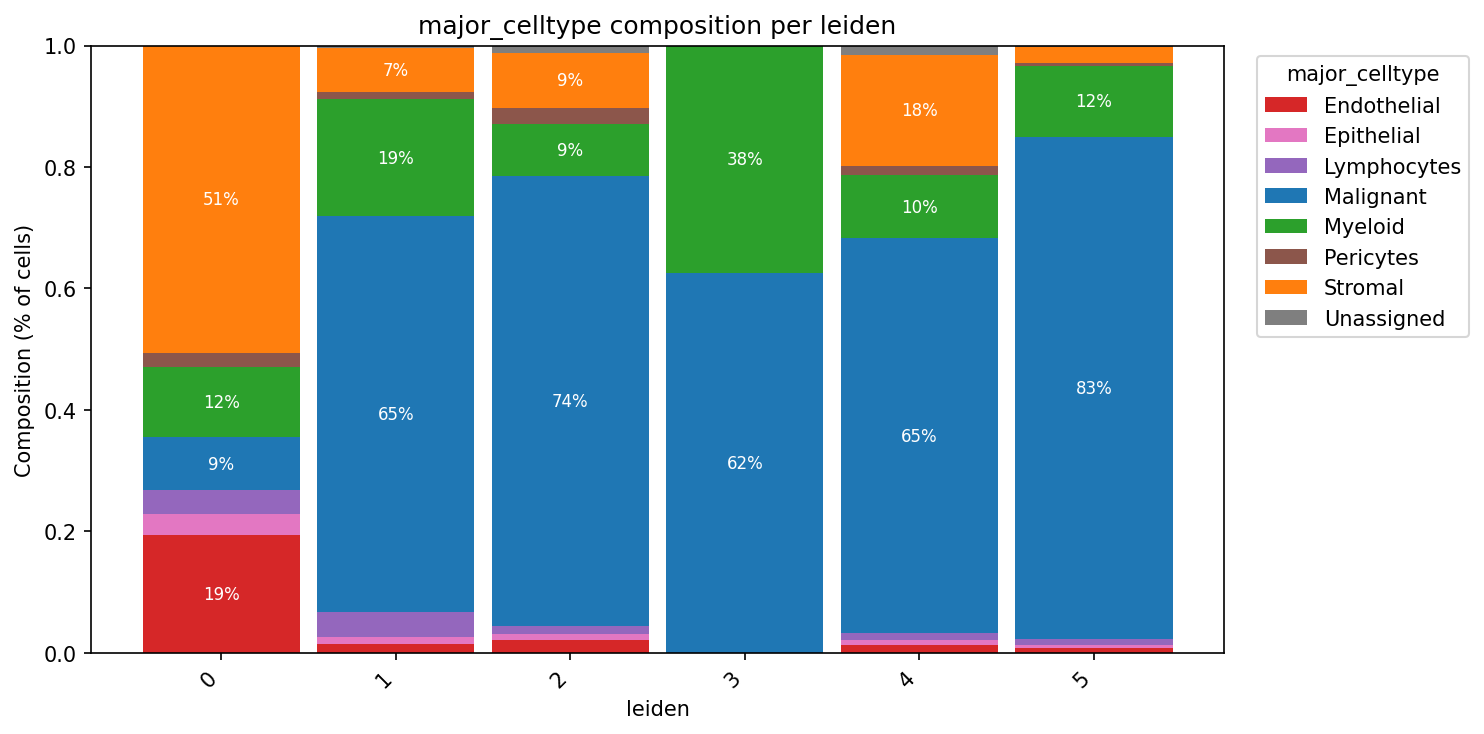

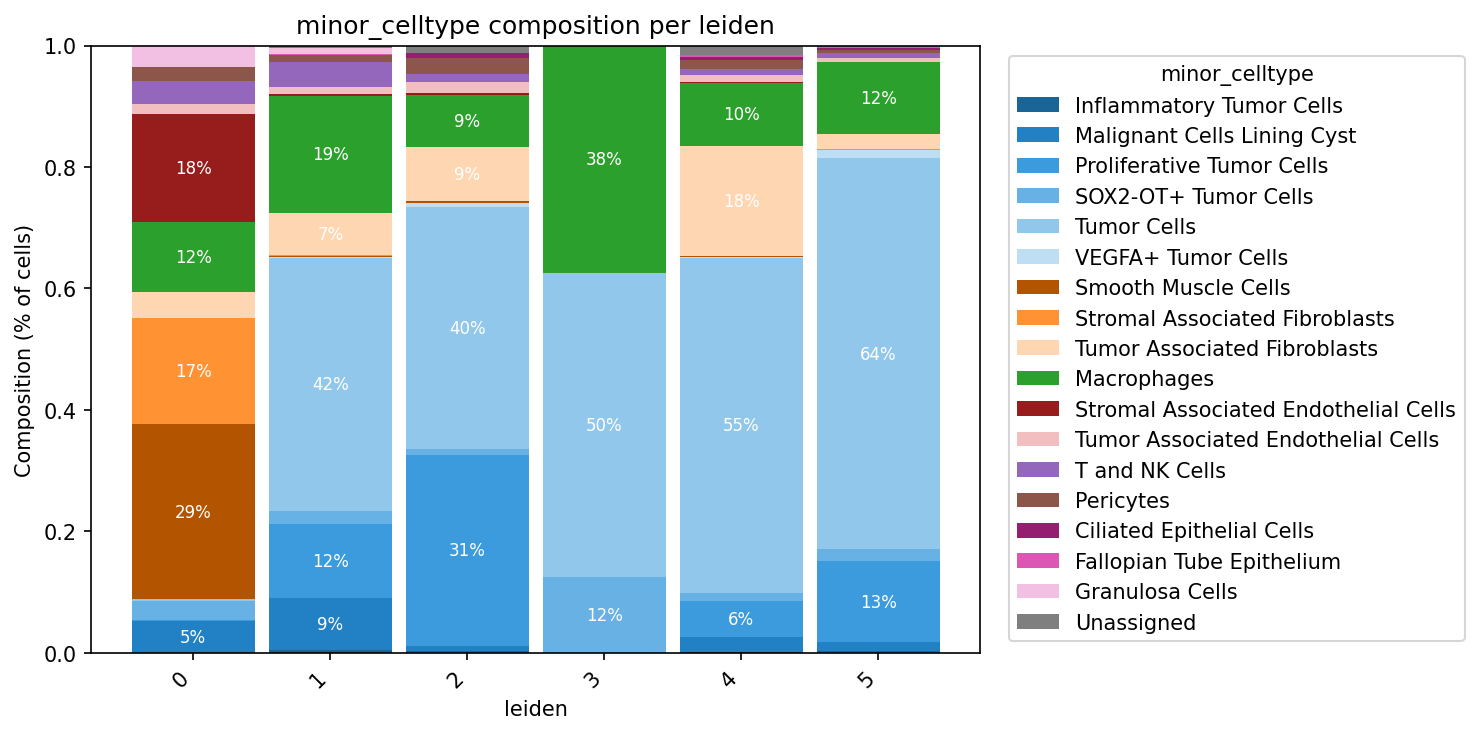

In [ ]:
# Build coherent palettes & orders
parent_pal, child_pal, parent_order, child_order = make_hierarchical_palettes(
    adata.obs,
    parent_key="major_celltype",
    child_key="minor_celltype",
    # Optionally enforce your own lineage order:
    # parent_order=["Immune","Stromal","Endothelial","Epithelial","Adipocyte"],
    child_order="alpha",                 # or "freq"
    shade_lightness=(0.35, 0.85)
)

# (A) 100% stacked bars by lineage (coarse)
plot_df_types = plot_cluster_composition_stacked(
    adata.obs,
    cluster_key="leiden",
    type_key="major_celltype",
    cluster_order=["0","1","2","3","4",],  # your preferred cluster order
    strict_order=False,
    palette=parent_pal,
    percent_labels=True
)

# (B) 100% stacked bars by subtypes (fine), colors are shades within lineage color
plot_df_subtypes = plot_cluster_composition_stacked(
    adata.obs,
    cluster_key="leiden",
    type_key="minor_celltype",
    cluster_order=["0","1","2","3","4",],
    strict_order=False,
    palette=child_pal,
    # NEW: order subtypes grouped by their parent lineage
    type_order=child_order,              # requires tiny tweak shown above
    percent_labels=True
)


## Visualize spatial niche distributions within an H&E region of interest

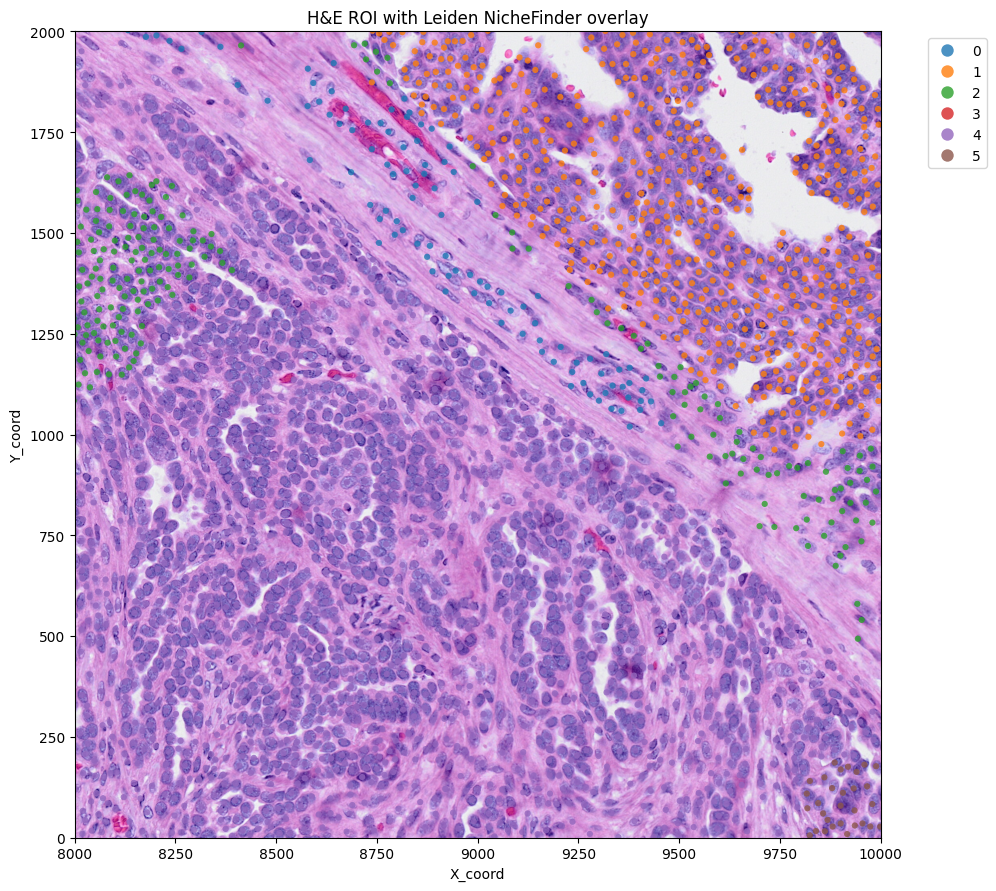

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Region of interest in H&E pixel space
xlim = (8000, 10000)
ylim = (0, 2000)

x0, x1 = xlim
y0, y1 = ylim

# --- Crop ROI from the WSI
roi = wsi[y0:y1, x0:x1, :]  # note: numpy indexing is [row=y, col=x]

fig, ax = plt.subplots(figsize=(10, 10))

# Show the H&E ROI
ax.imshow(roi, origin="upper", extent=(x0, x1, y1, y0))  
# ^ extent maps the array coords into the same coordinate system as X_he, Y_he
#   origin="upper" keeps top-left = (0,0)

# Overlay scatter using aligned coords
sns.scatterplot(
    data=adata.obs,
    x="X_coord", y="Y_coord",
    hue="leiden",          # categorical cluster
    palette="tab10",
    s=20, alpha=0.8,
    ax=ax,
    linewidth=0
)

# Match the crop window
ax.set_xlim(x0, x1)
ax.set_ylim(y1, y0)  # because origin="upper" flips Y
ax.invert_yaxis()
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    scatterpoints=1,       # how many points to show per entry
    markerscale=2          # scale factor for the legend markers
)
ax.set_title("H&E ROI with Leiden NicheFinder overlay")

plt.tight_layout()
plt.show()


# Finetune model

We can also easily fine-tune the model to a dataset we have. For this however we need to make sure we have the pathway matrix computed with PROGENy.

## Pathway matrix

### Helper functions

In [51]:
import argparse
import warnings
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)
sc.set_figure_params(figsize=(3, 3), frameon=False)

def get_pathway_score(
    adata: sc.AnnData,
    spatial_key: str = "spatial_he",
    bw: int = 100,
    cutoff: float = 0.1,
    net: pd.DataFrame = None,
) -> Tuple[sc.AnnData, sc.AnnData]:
    """
    Compute pathway activation using decoupler (ULM), after spatial smoothing with KNN on coordinates.

    Steps:
      1) normalize_total + log1p
      2) store normalized counts in adata.layers["norm"]
      3) build spatial KNN graph via dc.pp.knn(..., key=spatial_key)
      4) smooth adata.X with graph connectivities
      5) run dc.mt.ulm to compute scores -> stored in adata.obsm['score_ulm']

    Returns the modified AnnData and the same object for convenience.
    """
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    adata.layers["norm"] = adata.X.copy()
    dc.pp.knn(adata, key=spatial_key, bw=bw, cutoff=cutoff)
    adata.X = adata.obsp[f"{spatial_key}_connectivities"].dot(adata.X)

    dc.mt.ulm(data=adata, net=net)
    _ = dc.pp.get_obsm(adata=adata, key="score_ulm")
    return adata, adata

### Compute pathway

In [52]:
net_df = dc.op.progeny(organism='human')

In [53]:
# these are the pathways selected in this work
keep_cols = ['Androgen','EGFR','Estrogen','JAK-STAT','MAPK','NFkB','PI3K',
             'TGFb','TNFa','VEGF']

In [59]:
# Compute scores
_, adata_scored = get_pathway_score(
    adata, spatial_key='spatial', bw=100, cutoff=0.1, net=net_df
)

# Keep only requested pathways (if present)
score_df = adata_scored.obsm["score_ulm"]
existing = [p for p in keep_cols if p in score_df.columns]
if not existing:
    # If none of the requested pathways exist, keep all
    existing = list(score_df.columns)
score_df = score_df.loc[:, existing]

In [61]:
# Save
out_path = 'data/pathway_matrix.parquet'
score_df.to_parquet(out_path)

## Run finetuning

In [49]:
from spatialfusion.finetune.finetune import finetune_models

We put the data into the same system as for inference

In [62]:
pathway_matrix = pd.read_parquet(out_path)

In [63]:
adatas = {sample_name: adata}

preloaded_data = {
    sample_name: (uni_df.loc[adata.obs_names], scgpt_df.loc[adata.obs_names])
}

preloaded_pathway_data = {
    sample_name: pathway_matrix.loc[adata.obs_names]
}

And like before we specify the model we want to train as well as where to save the finetuned model.

In [65]:
ae_model_dir = pl.Path('../data/checkpoint_dir_ae/')
gcn_model_dir =  pl.Path('../data/checkpoint_dir_gcn/')

In general, we keep the epochs small; try between 5 and 15 epochs for the AE and/or GCN.
On a A6000 GPU this takes <30 sec.

In [66]:
finetune_models(
    samples=[sample_name],
    pretrained_ae=ae_model_dir / "spatialfusion-multimodal-ae.pt",
    pretrained_gcn=gcn_model_dir / "spatialfusion-full-gcn.pt", 
    save_dir='data/finetuned_model',
    preloaded_data=preloaded_data,   
    adatas=adatas,                  
    preloaded_pathway_data=preloaded_pathway_data,
    ae_epochs=5,
    gcn_epochs=5,
    ae_batch_size=128,
    gcn_batch_size=2,
    latent_dim=64,
    knn_k=30,
    subgraph_size=5000,
    stride=2500,
    use_cls_loss=True,
    spatial_key='spatial',
)

[AE 1] total=0.8890


[AE 2] total=0.8473


[AE 3] total=0.8173


[AE 4] total=0.7958


[AE 5] total=0.7806
[SUBSET_Xenium_Ovarian-5k] Using preloaded pathway activation data.
[SUBSET_Xenium_Ovarian-5k] Attached 10 label dimensions.


[GCN 1] total=1.3064


[GCN 2] total=1.2668


[GCN 3] total=1.2772


[GCN 4] total=1.2716


[GCN 5] total=1.2941
✓ Finetuning complete.


(PairedAE(
   (encoder1): EncoderAE(
     (model): Sequential(
       (0): Linear(in_features=1536, out_features=64, bias=True)
       (1): ReLU()
       (2): Linear(in_features=64, out_features=64, bias=True)
     )
   )
   (encoder2): EncoderAE(
     (model): Sequential(
       (0): Linear(in_features=512, out_features=64, bias=True)
       (1): ReLU()
       (2): Linear(in_features=64, out_features=64, bias=True)
     )
   )
   (decoder1): Decoder(
     (net): Sequential(
       (0): Linear(in_features=64, out_features=64, bias=True)
       (1): ReLU()
       (2): Linear(in_features=64, out_features=1536, bias=True)
     )
   )
   (decoder2): Decoder(
     (net): Sequential(
       (0): Linear(in_features=64, out_features=64, bias=True)
       (1): ReLU()
       (2): Linear(in_features=64, out_features=512, bias=True)
     )
   )
 ),
 GCNAutoencoder(
   (gcn_layers): ModuleList(
     (0): GraphConv(in=64, out=10, normalization=both, activation=None)
     (1): GraphConv(in=10, out=10

## Embed finetuned

In [67]:
ae_inputs_by_sample = {
    sample_name: AEInputs(adata=adata, z_uni=uni_df, z_scgpt=scgpt_df),
}

In [68]:
# this uses the average version
embeddings_finetuned_df = run_full_embedding(
    ae_inputs_by_sample=ae_inputs_by_sample,
    ae_model_path='data/finetuned_model/paired_model_finetuned.pt',
    gcn_model_path='data/finetuned_model/gcn_finetuned/model.pt',
    device="cuda:0",
    combine_mode="average",
    spatial_key='spatial',
    celltype_key=None,
    save_ae_dir=None,  # optional
)

Running GCN inference: 100%|███████████████████████████████████| 1/1 [00:00<00:00, 40.98it/s]


In [69]:
embeddings_finetuned_df.set_index('cell_id').to_parquet('data/SpatialFusion_finetuned.parquet')

# Compare finetuned and pre-trained

## Analysis

In [70]:
embeddings_df = pd.read_parquet('data/SpatialFusion.parquet')
embeddings_df_finetuned = pd.read_parquet('data/SpatialFusion_finetuned.parquet')

In [71]:
adata.obsm['SpatialFusion'] = embeddings_df.loc[adata.obs_names,['0','1','2','3','4','5','6','7','8','9']]
adata.obsm['SpatialFusion_finetuned'] = embeddings_df_finetuned.loc[adata.obs_names,['0','1','2','3','4','5','6','7','8','9']]

In [72]:
sc.pp.neighbors(adata, use_rep='SpatialFusion')

In [73]:
sc.tl.leiden(adata, resolution=0.05, flavor="igraph", n_iterations=2)

In [74]:
adata.obs.leiden.value_counts()

leiden
4    25824
1     6290
3     5984
2     4244
5     3706
0      643
Name: count, dtype: int64

In [75]:
adata.obs.leiden = adata.obs.leiden.astype(str).astype('category')

In [76]:
adata.obs['SpatialFusion_niche'] = adata.obs.leiden

In [77]:
sc.pp.neighbors(adata, use_rep='SpatialFusion_finetuned')

In [82]:
sc.tl.leiden(adata, resolution=0.05, flavor="igraph", n_iterations=2)

In [83]:
adata.obs.leiden.value_counts()

leiden
5    19094
2    15274
1     5673
3     3575
0     3015
4       53
6        7
Name: count, dtype: int64

In [85]:
adata.obs.leiden = adata.obs.leiden.astype(str).astype('category')

In [86]:
adata.obs['SpatialFusion_finetuned_niche'] = adata.obs.leiden

In [87]:
plt.style.use('default')

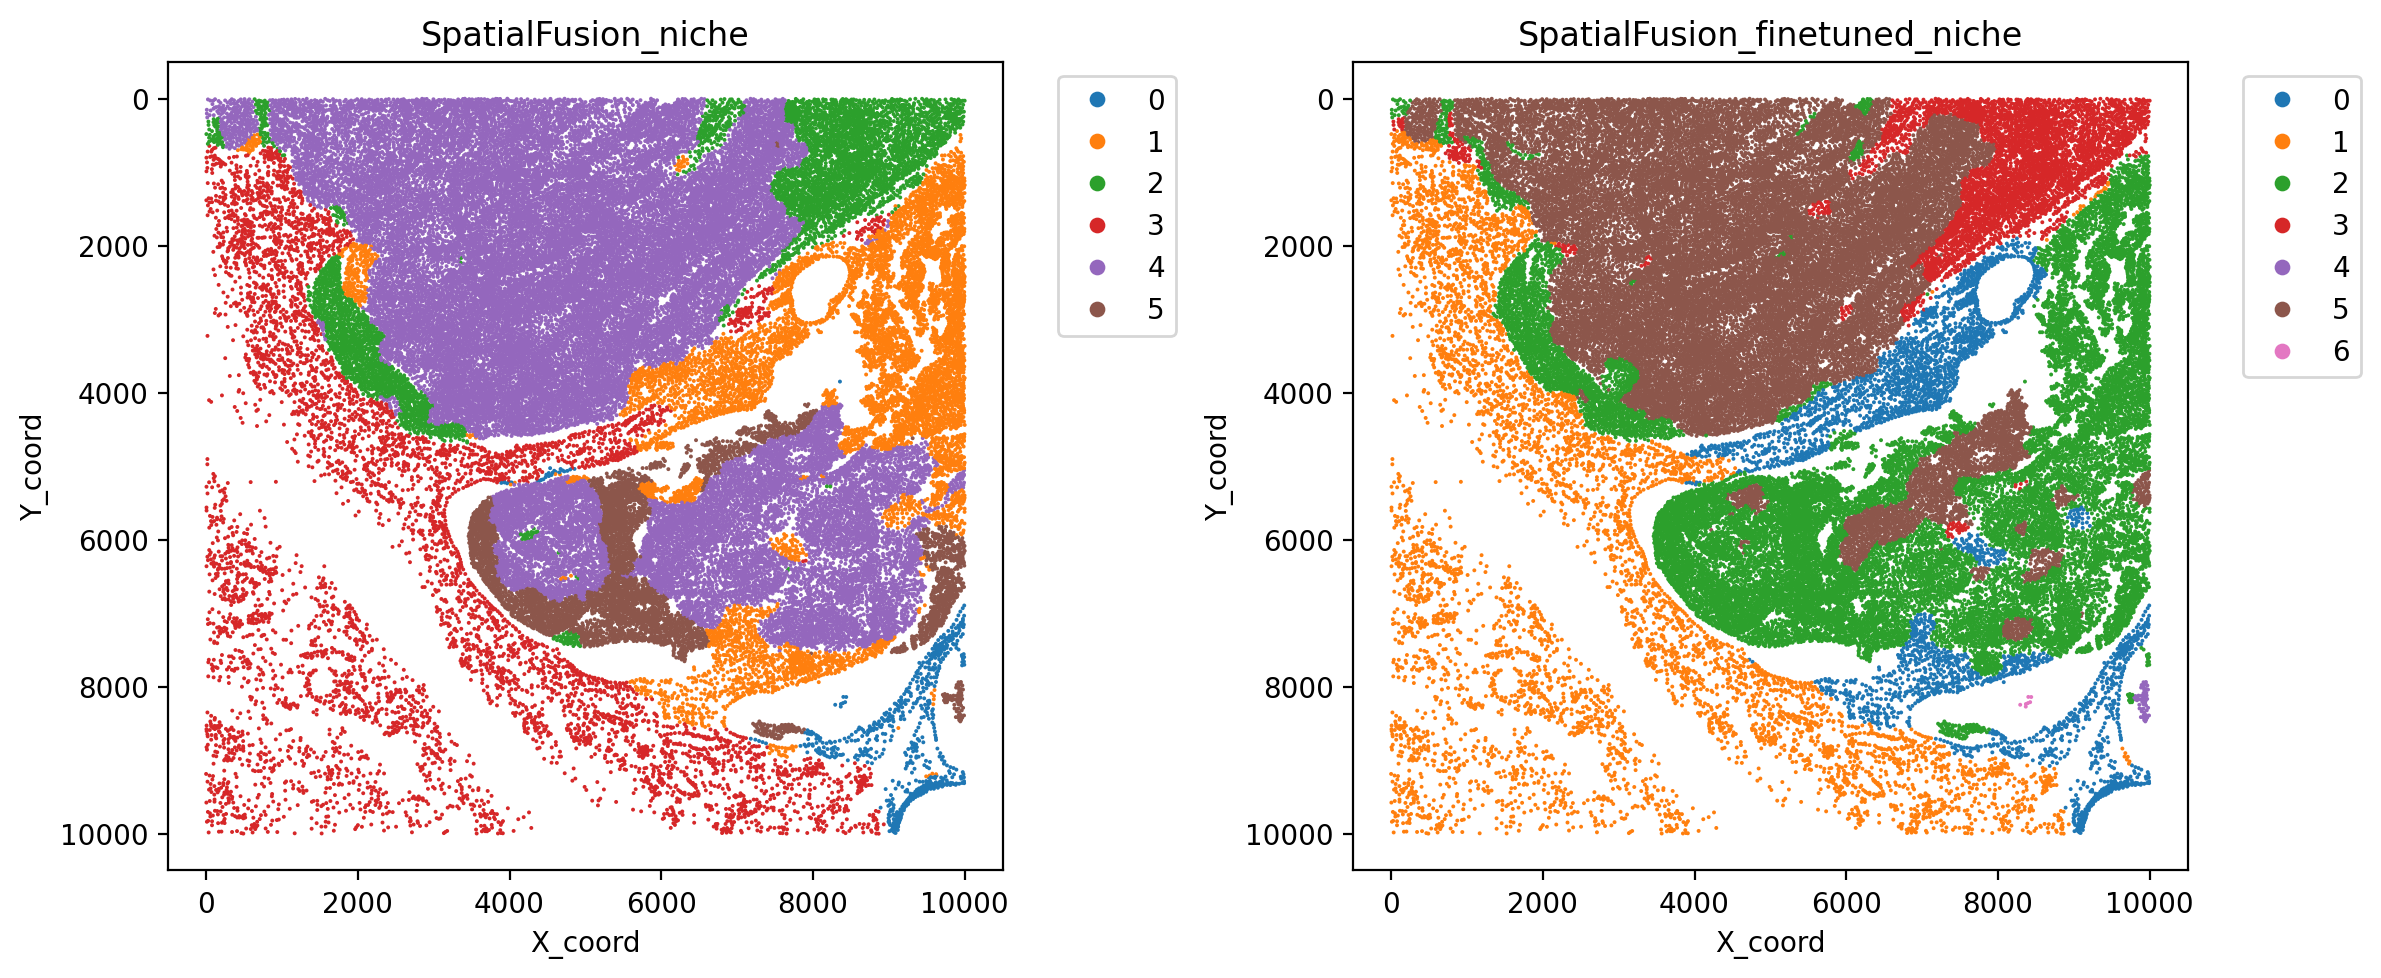

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ---- Plot 1: SpatialFusion_niche ----
sns.scatterplot(
    data=adata.obs,
    x='X_coord', y='Y_coord',
    hue='SpatialFusion_niche',
    palette="tab10",
    s=2,
    linewidth=0,
    ax=axes[0]
)
axes[0].invert_yaxis()
axes[0].set_title("SpatialFusion_niche")
axes[0].legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    scatterpoints=1,
    markerscale=4
)

# ---- Plot 2: SpatialFusion_finetuned_niche ----
sns.scatterplot(
    data=adata.obs,
    x='X_coord', y='Y_coord',
    hue='SpatialFusion_finetuned_niche',
    palette="tab10",
    s=2,
    linewidth=0,
    ax=axes[1]
)
axes[1].invert_yaxis()
axes[1].set_title("SpatialFusion_finetuned_niche")
axes[1].legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    scatterpoints=1,
    markerscale=4
)

plt.tight_layout()
plt.show()
